# scRNA-seq

In [42]:
import warnings
warnings.filterwarnings('ignore')

import os
from pathlib import Path
import scvi
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sn
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

scvi.settings.seed = 30

Seed set to 30


### Annotate Single Cells with Cell Type Label

In [43]:
######################################################## load reference
ref_data = sc.read_h5ad('TS_Mammary.h5ad')

######################################################## load data
file = 'sc_rna_seq_combined.h5ad' ### <--- data
dat1 = sc.read_h5ad(file)

######################################################## filter
sc.pp.filter_genes(dat1, min_cells = 100)

######################################################## concatenate data
dat1 = dat1.concatenate(ref_data)

In [44]:
######################################################## normalize data
dat1.layers["counts"] = dat1.X.copy()
sc.pp.normalize_total(dat1, target_sum = 10000)
sc.pp.log1p(dat1)
dat1.raw = dat1

######################################################## filter
sc.pp.highly_variable_genes(dat1, flavor = 'seurat_v3', n_top_genes=2000, layer = 'counts', batch_key='batch', subset = True)

######################################################## train model
scvi.model.SCVI.setup_anndata(dat1, layer = 'counts', 
                              batch_key='batch')
vae = scvi.model.SCVI(dat1) ### initialize the model
vae.train(max_epochs=25)

######################################################## predict label
dat1.obs['cell_ontology_class'] = dat1.obs['cell_ontology_class'].cat.add_categories('Unknown')
dat1.obs = dat1.obs.fillna(value = {'cell_ontology_class': 'Unknown'})

lvae = scvi.model.SCANVI.from_scvi_model(vae, adata = dat1, unlabeled_category = 'Unknown', labels_key = 'cell_ontology_class')
lvae.train(max_epochs=25)

dat1.obs['predicted'] = lvae.predict(dat1)
dat1.obs['bc2'] = dat1.obs.index.map(lambda x: x[:-2])

######################################################## store labels in a dictionary
cell_mapper = dict(zip(dat1.obs.bc2, dat1.obs.predicted))

######################################################## map to data
dat1 = sc.read_h5ad(file)
dat1.var_names_make_unique()
dat1.obs['cell_type'] = dat1.obs.index.map(cell_mapper)
dat1.obs.groupby('Sample').count()
dat1.obs

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/25 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


INFO     Training for 25 epochs.                                                                                   


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/25 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


Sample  doublet  n_genes  n_genes_by_counts  \
CID3941_ACAGCCGAGCTCTCGG    ER_CID3941    False     2456               2456   
CID3941_ACGCAGCCAGCTGTAT    ER_CID3941    False     2305               2305   
CID3941_CATGACAGTAGAGCTG    ER_CID3941    False     1944               1944   
CID3941_CGAACATTCCCAACGG    ER_CID3941    False     1492               1492   
CID3941_CTAGAGTGTAAAGGAG    ER_CID3941    False     1353               1353   
...                                ...      ...      ...                ...   
CID4465_CGTGTCTAGTAAGTAC  TNBC_CID4465    False     1461               1461   
CID4465_GAGTCCGGTGAGGGAG  TNBC_CID4465    False     1090               1090   
CID4465_GTAACGTCAAGCCATT  TNBC_CID4465    False      268                268   
CID4465_TGAGCCGCACGTCTCT  TNBC_CID4465    False     1324               1324   
CID4465_TGGCCAGGTCCGTGAC  TNBC_CID4465    False      552                552   

                          total_counts  total_counts_mt  pct_counts_mt  \
CID3941_ACAGCCGAGCTCTCGG        6685.0            578.0       8.646223   
CID3941_ACGCAGCCAGCTGTAT        7904.0            740.0       9.362349   
CID3941_CATGACAGTAGAGCTG        4935.0            251.0       5.086120   
CID3941_CGAACATTCCCAACGG        3354.0            277.0       8.258796   
CID3941_CTAGAGTGTAAAGGAG        3263.0            375.0      11.492492   
...                                ...              ...            ...   
CID4465_CGTGTCTAGTAAGTAC        2954.0             92.0       3.114421   
CID4465_GAGTCCGGTGAGGGAG        1888.0             61.0       3.230932   
CID4465_GTAACGTCAAGCCATT         389.0             30.0       7.712082   
CID4465_TGAGCCGCACGTCTCT        2458.0            113.0       4.597234   
CID4465_TGGCCAGGTCCGTGAC         762.0             18.0       2.362205   

                          total_counts_ribo  pct_counts_ribo  \
CID3941_ACAGCCGAGCTCTCGG             1031.0        15.422588   
CID3941_ACGCAGCCAGCTGTAT             1447.0        18.307186   
CID3941_CATGACAGTAGAGCTG              980.0        19.858156   
CID3941_CGAACATTCCCAACGG              492.0        14.669052   
CID3941_CTAGAGTGTAAAGGAG              643.0        19.705791   
...                                     ...              ...   
CID4465_CGTGTCTAGTAAGTAC              291.0         9.851049   
CID4465_GAGTCCGGTGAGGGAG              161.0         8.527543   
CID4465_GTAACGTCAAGCCATT               34.0         8.740359   
CID4465_TGAGCCGCACGTCTCT              181.0         7.363710   
CID4465_TGGCCAGGTCCGTGAC               45.0         5.905512   

                                                         cell_type  
CID3941_ACAGCCGAGCTCTCGG                     vein endothelial cell  
CID3941_ACGCAGCCAGCTGTAT                     vein endothelial cell  
CID3941_CATGACAGTAGAGCTG                     vein endothelial cell  
CID3941_CGAACATTCCCAACGG                     vein endothelial cell  
CID3941_CTAGAGTGTAAAGGAG                     vein endothelial cell  
...                                                            ...  
CID4465_CGTGTCTAGTAAGTAC  luminal epithelial cell of mammary gland  
CID4465_GAGTCCGGTGAGGGAG  luminal epithelial cell of mammary gland  
CID4465_GTAACGTCAAGCCATT  luminal epithelial cell of mammary gland  
CID4465_TGAGCCGCACGTCTCT  luminal epithelial cell of mammary gland  
CID4465_TGGCCAGGTCCGTGAC  luminal epithelial cell of mammary gland  

[10318 rows x 10 columns]

### Data Analysis

In [45]:
######################################################## filter
sc.pp.filter_genes(dat1, min_cells = 100)

######################################################## normalize data
dat1.layers['counts'] = dat1.X.copy()
sc.pp.normalize_total(dat1, target_sum = 10000)
sc.pp.log1p(dat1)
dat1.raw = dat1

######################################################## train model
scvi.model.SCVI.setup_anndata(dat1, layer='counts',
                              categorical_covariate_keys=['Sample'],
                              continuous_covariate_keys=['pct_counts_mt', 'total_counts', 'pct_counts_ribo'])

model = scvi.model.SCVI(dat1)
model.train(max_epochs=25)

######################################################## prepare data for clustering
model.get_latent_representation().shape
dat1.obsm['X_scVI'] = model.get_latent_representation()
dat1.layers['scvi_normalized'] = model.get_normalized_expression(library_size=10000)

sc.pp.neighbors(dat1, use_rep = 'X_scVI')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/25 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


In [46]:
dat1

AnnData object with n_obs × n_vars = 10318 × 2000
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'cell_type', '_scvi_batch', '_scvi_labels'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors'
    obsm: '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs', 'X_scVI'
    layers: 'counts', 'scvi_normalized'
    obsp: 'distances', 'connectivities'

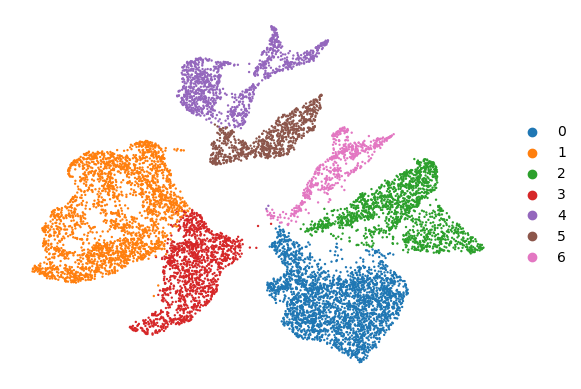

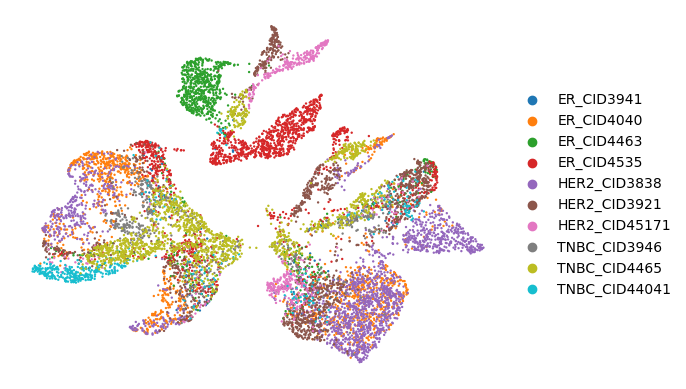

In [47]:
######################################################## plot umap, based on leiden clustering
sc.tl.umap(dat1)
sc.tl.leiden(dat1, resolution = 0.075)

sc.pl.umap(dat1, color = ['leiden'], frameon = False, title = "") ### leiden clustering
sc.pl.umap(dat1, color = ['Sample'], frameon = False, title = "", save='UMAP_sample_scrnaseq.png') ### sample

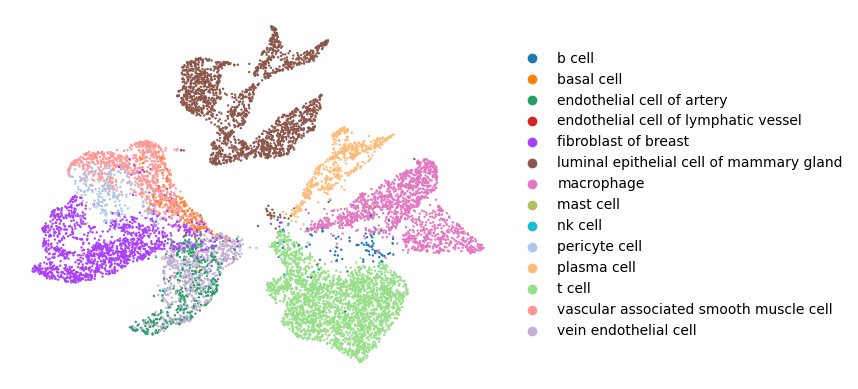

In [48]:
######################################################## plot umap, based on labelled cell type
sc.pl.umap(dat1, color = 'cell_type', frameon = False, title = "")
#ax = sc.pl.umap(dat1, show = False)
#sc.pl.umap(dat1[dat1.obs.cell_type.str.contains('macrophage')], palette = ['lightgreen'], color = 'cell_type', ax=ax)

In [49]:
dat1

AnnData object with n_obs × n_vars = 10318 × 2000
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'cell_type', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Sample_colors', 'cell_type_colors'
    obsm: '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs', 'X_scVI', 'X_umap'
    layers: 'counts', 'scvi_normalized'
    obsp: 'distances', 'connectivities'

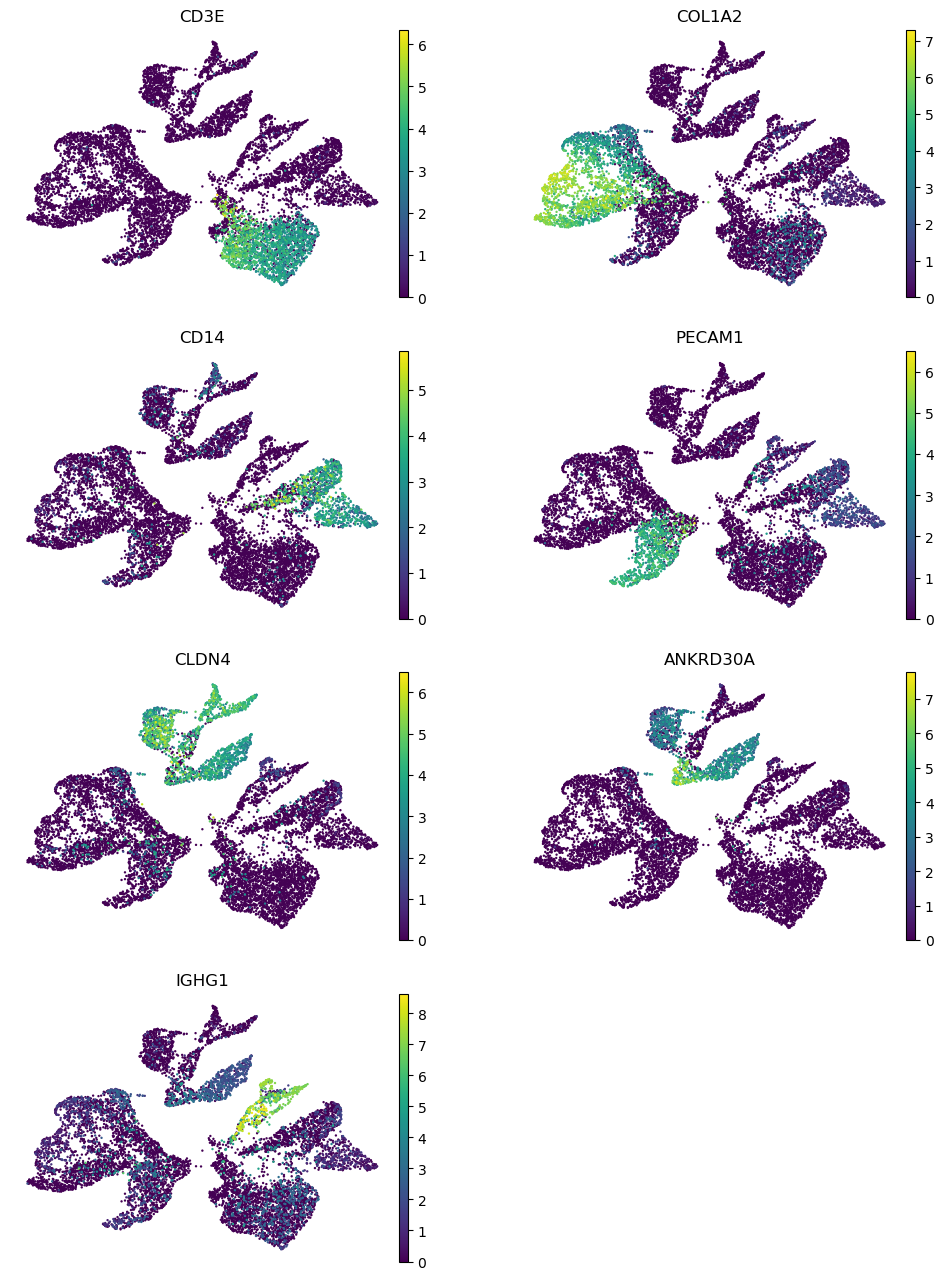

In [50]:
######################################################## plot biomarker genes
fig, axs = plt.subplots(4,2, figsize=(12,16))

sc.pl.umap(dat1, color = ['CD3E'], frameon = False, ax=axs[0,0], show=False) ### T cell
sc.pl.umap(dat1, color = ['COL1A2'] , frameon = False, ax=axs[0,1], show=False) ### fibroblast cell
sc.pl.umap(dat1, color = ['CD14'], frameon = False, ax=axs[1,0], show=False) ### macrophage
sc.pl.umap(dat1, color = ['PECAM1'] , frameon = False, ax=axs[1,1], show=False) ### vein endothelial cell
sc.pl.umap(dat1, color = ['CLDN4'], frameon = False, ax=axs[2,0], show=False) ### Luminal cell L1
sc.pl.umap(dat1, color = ['ANKRD30A'], frameon = False, ax=axs[2,1], show=False) ### Luminal cell L2, ANKRD30A
sc.pl.umap(dat1, color = ['IGHG1'], frameon = False, ax=axs[3,0], show=False) ### plasma cell
plt.delaxes(axs[3,1])
plt.savefig('biomarkers_scrnaseq.png')

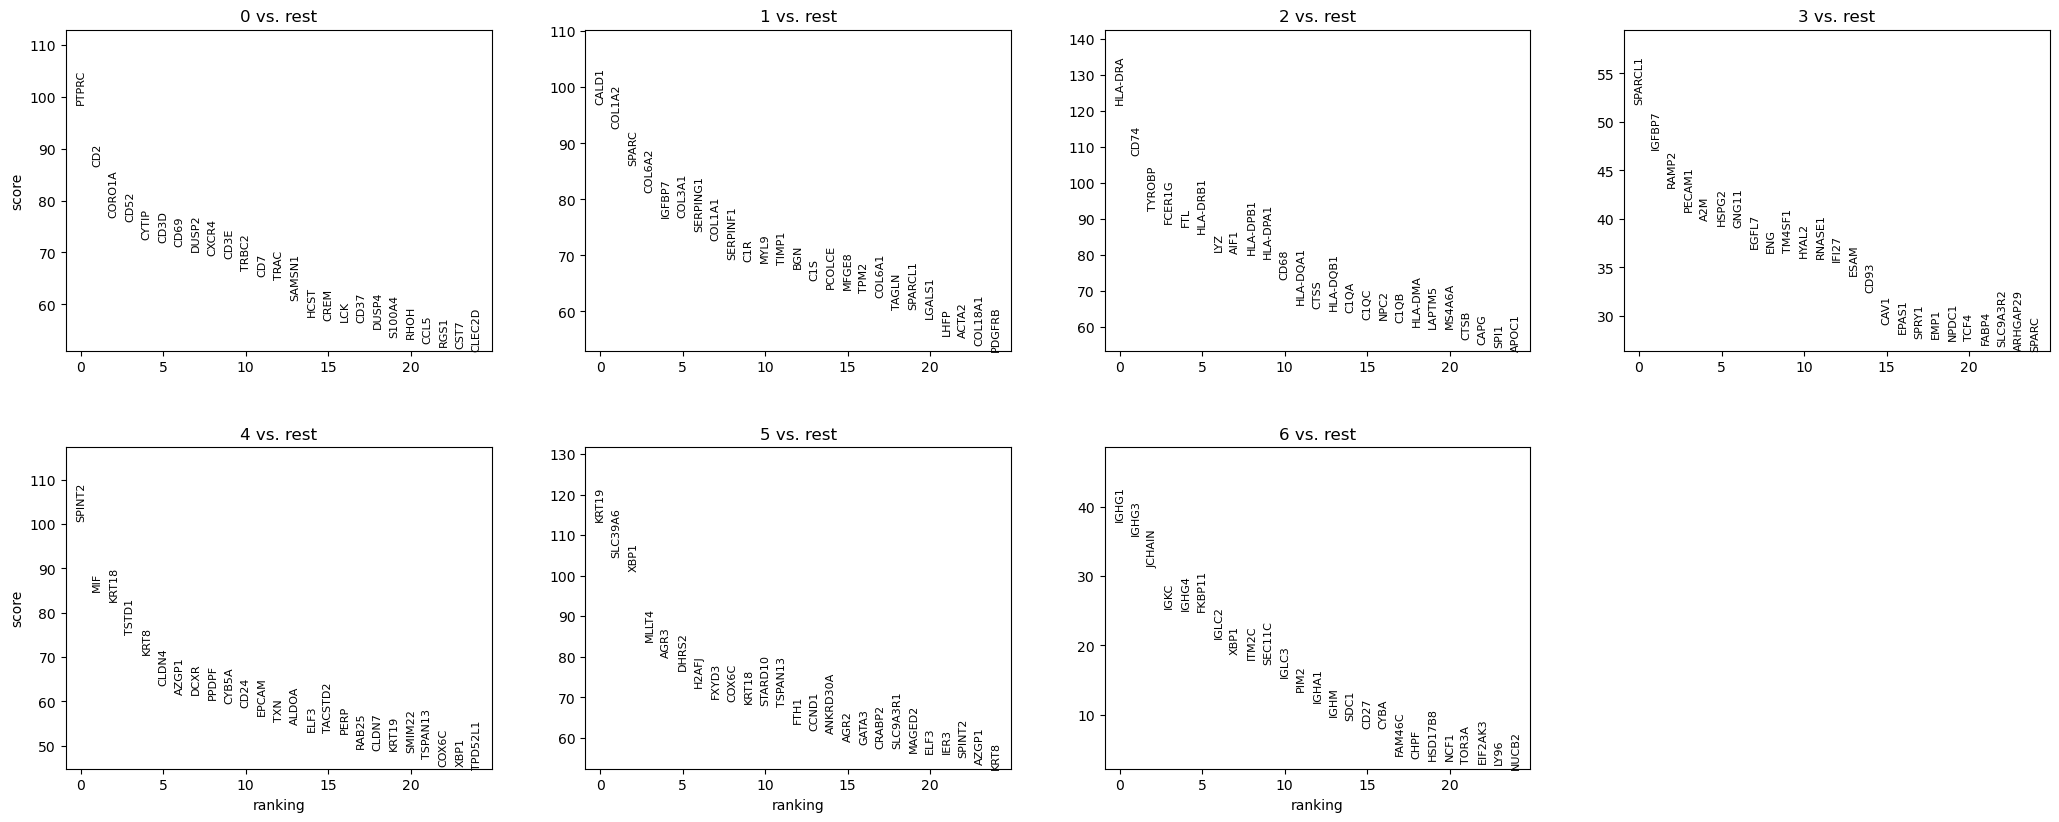

In [51]:
sc.tl.rank_genes_groups(dat1, 'leiden')
sc.pl.rank_genes_groups(dat1, n_genes=25, sharey=False)

In [52]:
######################################################## filter by gene ranking's p-values and log-fold-changes
markers = sc.get.rank_genes_groups_df(dat1, None)
#markers.to_csv('biomarker_raw.csv', index=False)
markers = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > 0.5)]
#markers.to_csv('biomarker_processed.csv', index=False)

######################################################## train model
markers_scvi = model.differential_expression(groupby = 'leiden')

######################################################## filter by FDR and log-fold-change mean
markers_scvi = markers_scvi[(markers_scvi['is_de_fdr_0.05']) & (markers_scvi.lfc_mean > 0.5)]

DE...:   0%|          | 0/7 [00:00<?, ?it/s]

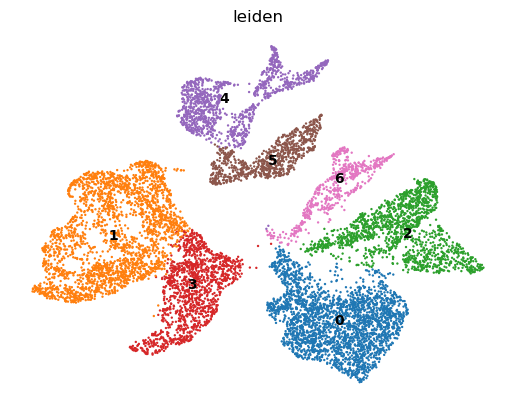

In [53]:
sc.pl.umap(dat1, color = ['leiden'], frameon = False, legend_loc = "on data")

In [54]:
dat1

AnnData object with n_obs × n_vars = 10318 × 2000
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'cell_type', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Sample_colors', 'cell_type_colors', 'rank_genes_groups'
    obsm: '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs', 'X_scVI', 'X_umap'
    layers: 'counts', 'scvi_normalized'
    obsp: 'distances', 'connectivities'

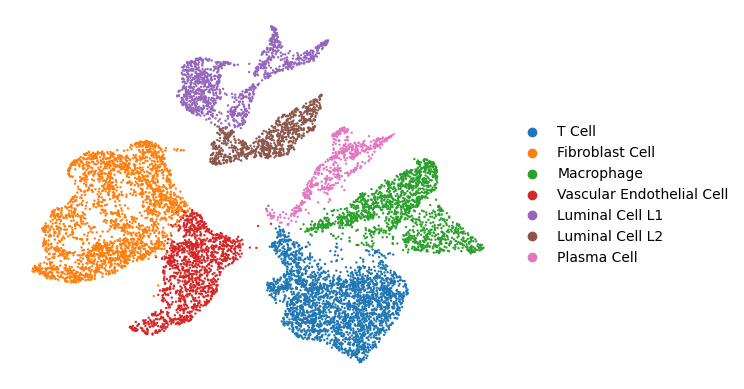

In [55]:
######################################################## labelling leiden clusters
cell_type_2 = {
"0":'T Cell',
"1":'Fibroblast Cell',
"2":'Macrophage',
"3":'Vascular Endothelial Cell',
"4":'Luminal Cell L1',
"5":'Luminal Cell L2',
"6":'Plasma Cell',
}

dat1.obs['cell_type_2'] = dat1.obs.leiden.map(cell_type_2)

######################################################## plot
sc.pl.umap(dat1, color = ['cell_type_2'], frameon = False, title="",  save='UMAP_scrnaseq.png')

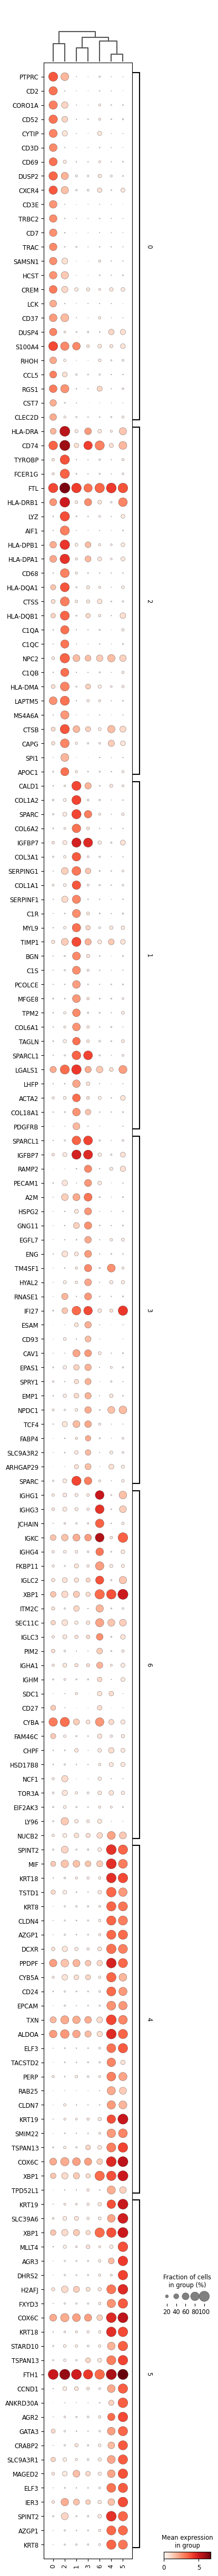

In [56]:
sc.pl.rank_genes_groups_dotplot(dat1, n_genes=25, save='dotplot_rank_genes_group.png', swap_axes=True)

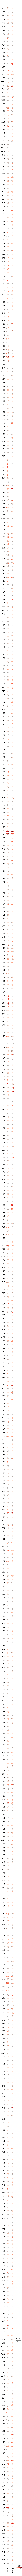

In [57]:
######################################################## plot APA genes, TR
list = 'merged_gs_polyadb_scrna.csv' ### <--- load gene list
gene_list = pd.read_csv(list)
gene_list = gene_list['gene_symbol'].tolist()
apa = dat1[:, gene_list]
#apa = apa[:, apa.var.sort_values('highly_variable_rank').index]
sc.pl.dotplot(apa, apa.var_names, groupby="cell_type_2", swap_axes=True, save='apa_genes_database_scrnaseq.png')

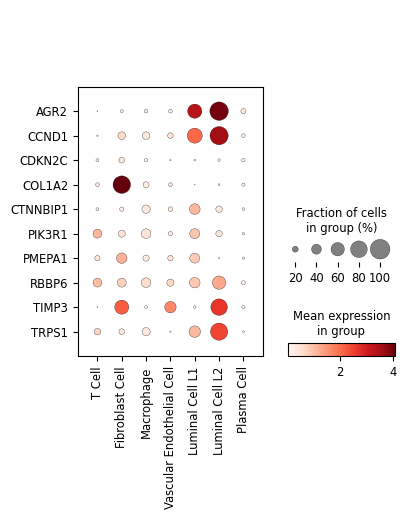

In [58]:
list = 'merged_paper_polyadb_scrna.csv' ### <--- load gene list
gene_list = pd.read_csv(list)
gene_list = gene_list['gene_symbol'].tolist()
apa2 = dat1[:, gene_list]
#apa2 = apa2[:, apa2.var.sort_values('highly_variable_rank').index]
sc.pl.dotplot(apa2, apa2.var_names, groupby="cell_type_2", swap_axes=True, save='apa_genes_scrnaseq.png')